In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/disaster-response-object-detection-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-response-object-detection-dataset/data.yaml
/kaggle/input/disaster-response-object-detection-dataset/val/labels/559.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1093.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1356.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/557.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/361.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1366.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1437.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/992.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1038.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/40.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/812.txt
/kaggle/input/disaster-response-object-detection-dataset/val/labels/1025.txt
/kaggle/input/di

✅ Dataset splits detected: ['train', 'val', 'test']
✅ Class names: ['person', 'fire', 'smoke', 'small_vehicle', 'large_vehicle', 'two_wheeler']

📸 Showing 4 sample images from 'train' split


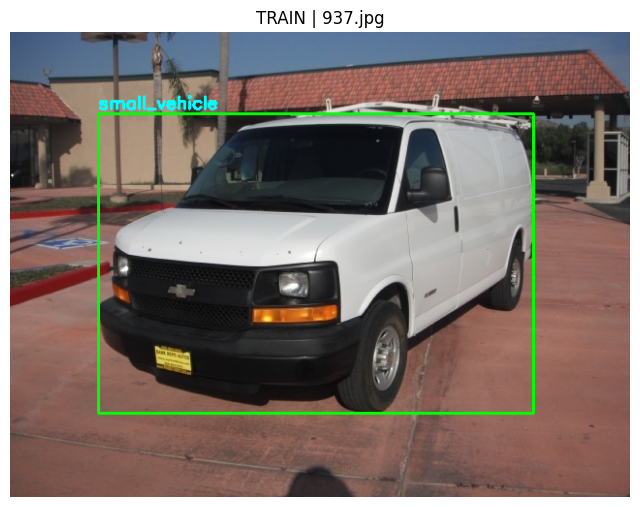

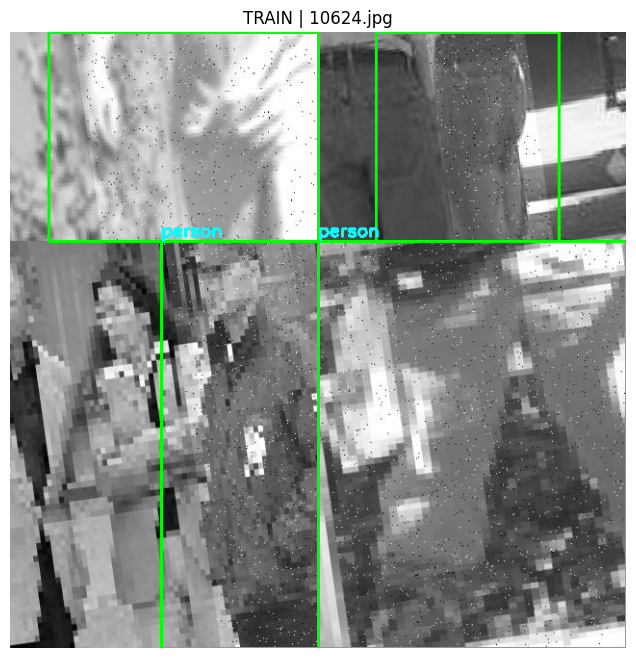

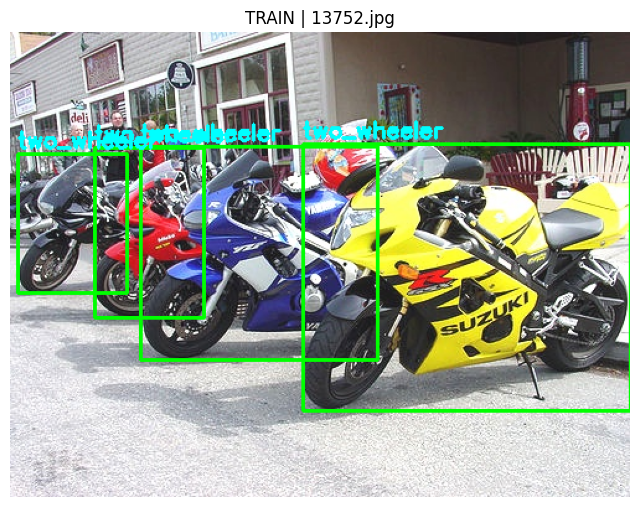

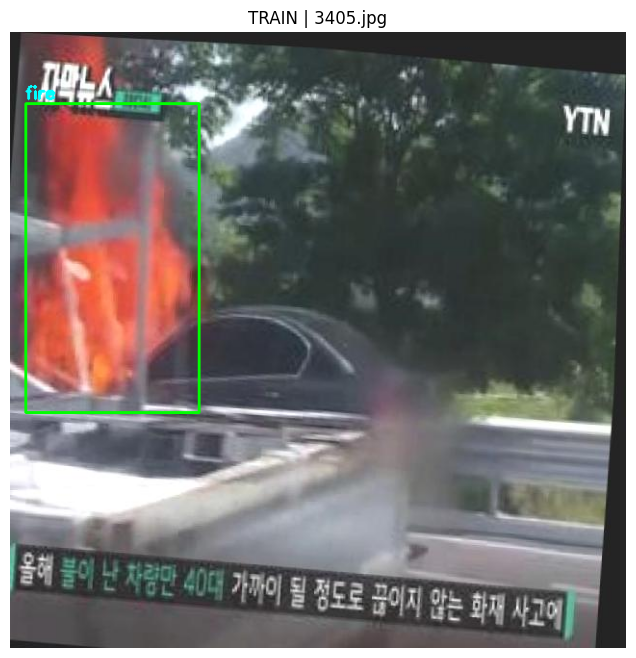


📸 Showing 4 sample images from 'val' split


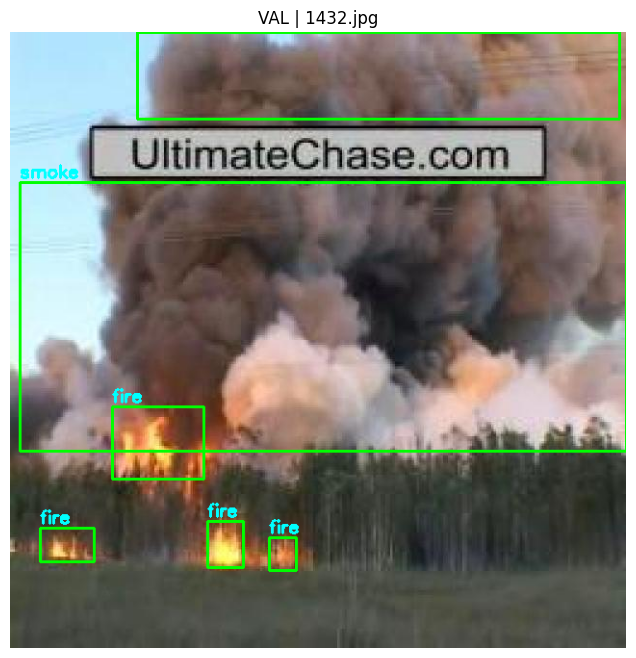

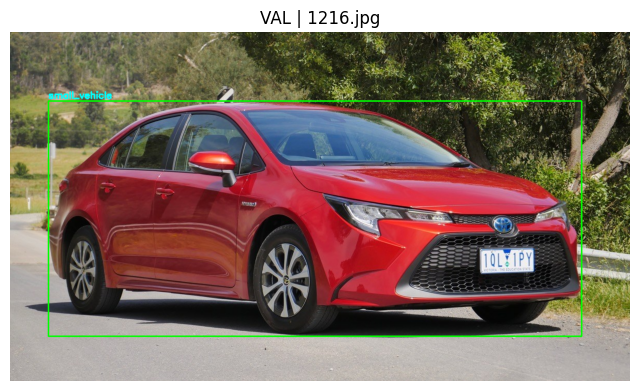

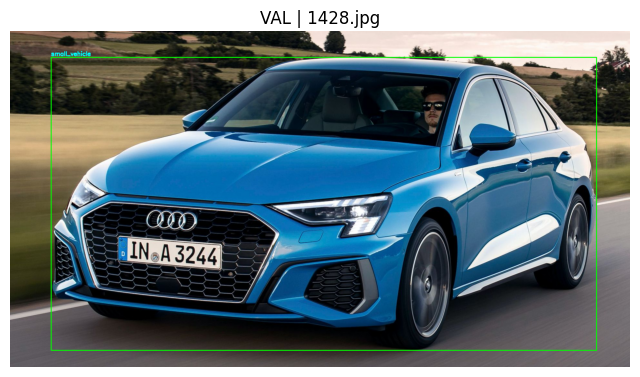

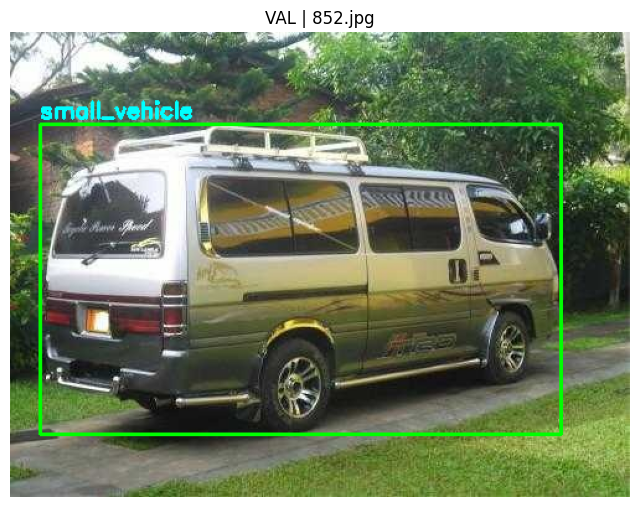


📸 Showing 4 sample images from 'test' split


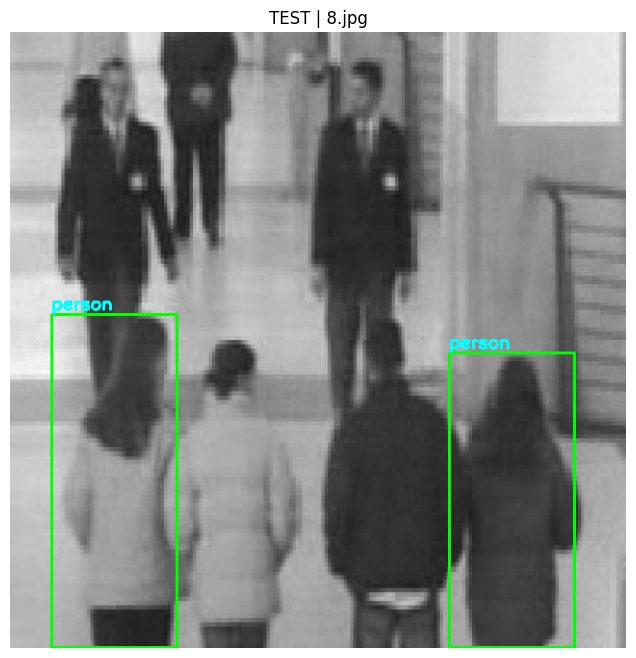

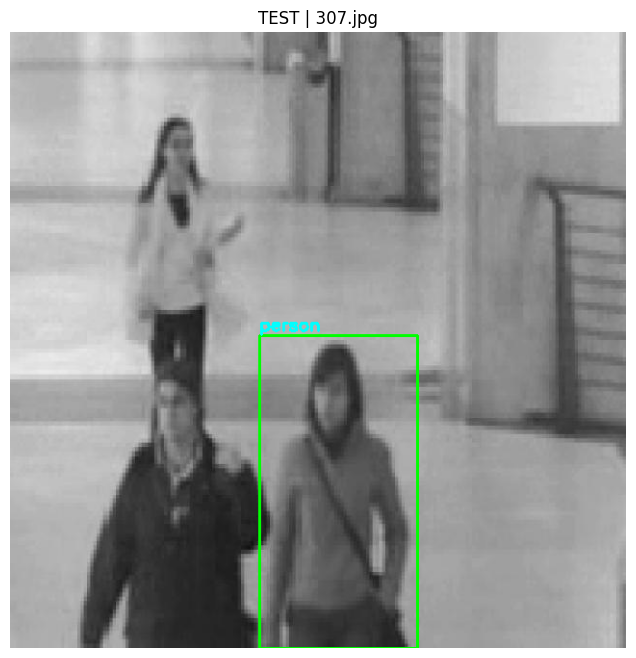

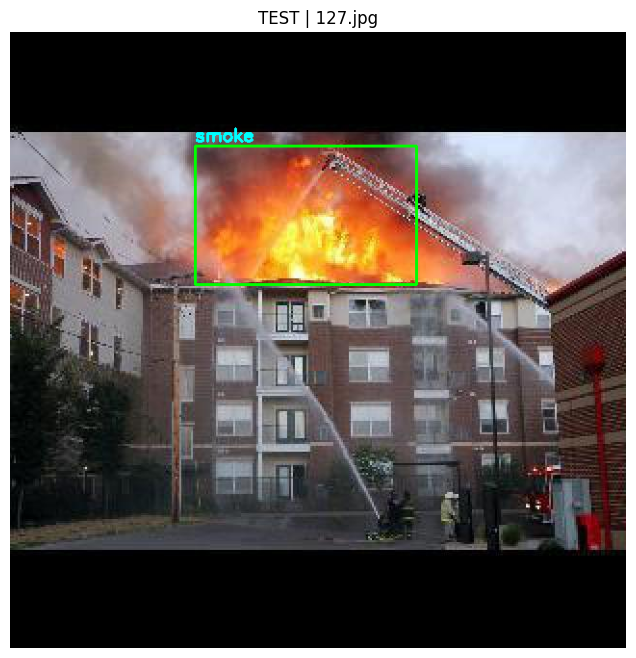

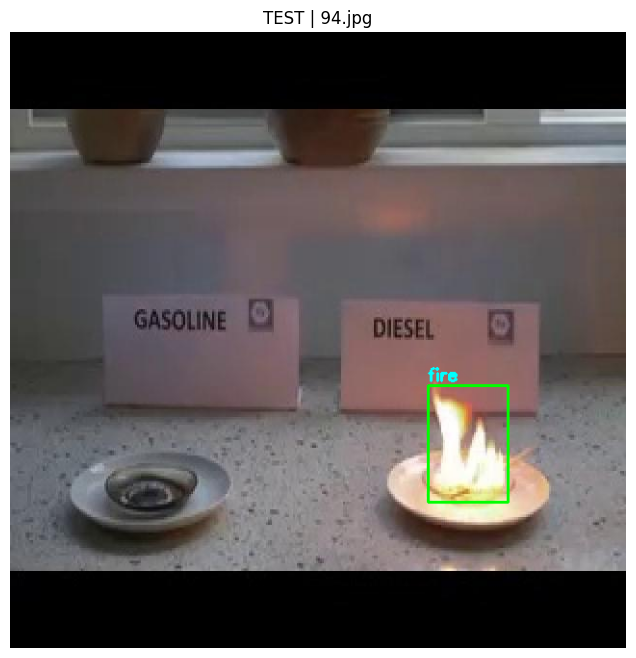

In [2]:
# ============================================================
# YOLO Dataset Visualization
# ============================================================

import os
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# 1️⃣ Load Dataset Config (already a dict, no need for open)
# ------------------------------------------------------------
data_cfg = {
    "train": "/kaggle/input/disaster-response-object-detection-dataset/train/images",
    "val": "/kaggle/input/disaster-response-object-detection-dataset/val/images",
    "test": "/kaggle/input/disaster-response-object-detection-dataset/test/images",
    "nc": 6,
    "names": [
        "person", "fire", "smoke", "small_vehicle", "large_vehicle", "two_wheeler"
    ]
}

class_names = data_cfg["names"]
splits = ["train", "val", "test"]

print(f"✅ Dataset splits detected: {splits}")
print(f"✅ Class names: {class_names}")

# ------------------------------------------------------------
# 2️⃣ Visualization Function
# ------------------------------------------------------------
def visualize_yolo_split(split_name, num_images=3):
    """
    Visualize YOLO-format annotations from dataset split.
    """
    image_dir = Path(data_cfg[split_name])
    # Labels assumed in a sibling folder 'labels'
    label_dir = image_dir.parent / "labels"

    # Check if labels exist
    if not label_dir.exists():
        print(f"⚠️ Label directory not found: {label_dir}")
        return

    # Get image files
    img_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
    if len(img_files) == 0:
        print(f"⚠️ No images found in {image_dir}")
        return

    random.shuffle(img_files)
    img_files = img_files[:num_images]

    print(f"\n📸 Showing {num_images} sample images from '{split_name}' split")

    for img_path in img_files:
        label_path = label_dir / f"{img_path.stem}.txt"
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        h, w = img.shape[:2]

        # Draw YOLO labels if exists
        if label_path.exists():
            with open(label_path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    cls = int(cls)
                    x1 = int((x - bw / 2) * w)
                    y1 = int((y - bh / 2) * h)
                    x2 = int((x + bw / 2) * w)
                    y2 = int((y + bh / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, class_names[cls], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"{split_name.upper()} | {img_path.name}")
        plt.show()

# ------------------------------------------------------------
# 3️⃣ Visualize Each Split
# ------------------------------------------------------------
visualize_yolo_split("train", num_images=4)
visualize_yolo_split("val", num_images=4)
visualize_yolo_split("test", num_images=4)

In [3]:
!pip install ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO
import cv2
import random
import yaml
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# 1️⃣ Load Dataset YAML
# ------------------------------------------------------------
yaml_path = Path("/kaggle/input/disaster-response-object-detection-dataset/data.yaml")

with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

print("✅ Dataset loaded successfully:")
print(yaml.dump(data_cfg, sort_keys=False))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Dataset loaded successfully:
train: ../train/images
val: ../val/images
test: ../test/images
nc: 6
names:
- person
- fire
- smoke
- small_vehicle
- large_vehicle
- two_wheeler



In [5]:
# ------------------------------------------------------------
# 2️⃣ Train YOLOv10n Model
# ------------------------------------------------------------
model = YOLO("yolov10n.pt")  # pre-trained model

results = model.train(
    data=str(yaml_path),
    epochs=20,
    imgsz=640,
    batch=16,
    project="/kaggle/working/disaster_response_object_yolov10_train",
    name="yolov10_disaster",
    device=0,
    workers=2,
    exist_ok=True
)

print("\n✅ Training complete. Best model saved in:")
print(model.ckpt_path)

Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/disaster-response-object-detection-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10_disaster, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1555       2400      0.787      0.779      0.792      0.627
                person        181        284      0.535      0.623      0.593      0.362
                  fire        675       1045      0.737      0.679      0.713      0.414
                 smoke        163        244      0.633      0.598      0.558       0.35
         small_vehicle        388        474       0.95      0.922       0.97      0.921
         large_vehicle        172        198      0.941       0.97      0.986      0.944
           two_wheeler        123        155      0.924      0.884      0.933      0.771
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/disaster_response_object_yolov10_train/yolov10_disaster

✅ Training complete. Best model saved in:
yolov10n.pt


In [6]:
# ------------------------------------------------------------
# 3️⃣ Evaluate on Validation and Test Sets
# ------------------------------------------------------------
print("\n📊 Evaluating on validation set...")
val_metrics = model.val(data=str(yaml_path), split="val")
print("\nValidation Results:")
#print(val_metrics)

print("\n📊 Evaluating on test set...")
test_metrics = model.val(data=str(yaml_path), split="test")
print("\nTest Results:")
#print(test_metrics)


📊 Evaluating on validation set...
Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,338 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 88.4±84.9 MB/s, size: 58.5 KB)
val: Scanning /kaggle/input/disaster-response-object-detection-dataset/val/labels... 1555 images, 24 backgrounds, 1 corrupt: 100% ━━━━━━━━━━━━ 1556/1556 775.5it/s 2.0s
val: /kaggle/input/disaster-response-object-detection-dataset/val/images/1058.jpg: 1 duplicate labels removed
val: /kaggle/input/disaster-response-object-detection-dataset/val/images/1283.jpg: 4 duplicate labels removed
val: /kaggle/input/disaster-response-object-detection-dataset/val/images/1373.jpg: 2 duplicate labels removed
val: /kaggle/input/disaster-response-object-detection-dataset/val/images/1377.jpg: 1 duplicate labels removed
val: /kaggle/input/disaster-response-object-detection-dataset/val/images/1414.jpg: 2 duplicate labels removed
val: /kaggl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1555       2400      0.792      0.778      0.792      0.627
                person        181        284      0.542      0.623      0.593      0.361
                  fire        675       1045      0.742      0.678      0.713      0.414
                 smoke        163        244      0.643      0.598      0.559       0.35
         small_vehicle        388        474      0.958      0.922      0.969      0.921
         large_vehicle        172        198      0.936       0.97      0.986      0.943
           two_wheeler        123        155      0.928      0.877      0.933      0.771
Speed: 0.8ms preprocess, 3.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

Validation Results:

📊 Evaluating on test set...
Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.7±1.5 ms, read: 5.1±0.6 MB/s, size: 33.5 KB)
val: Scanning /kaggle/input/disast

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        434        782      0.635      0.663      0.644      0.409
                person         79        139      0.576      0.656      0.579      0.383
                  fire        335        526      0.753      0.702      0.745      0.438
                 smoke         79        117      0.575      0.632      0.607      0.406
Speed: 1.3ms preprocess, 4.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2

Test Results:



🧠 Running inference for visualization...

image 1/1 /kaggle/input/disaster-response-object-detection-dataset/val/images/1412.jpg: 640x640 1 fire, 1 smoke, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


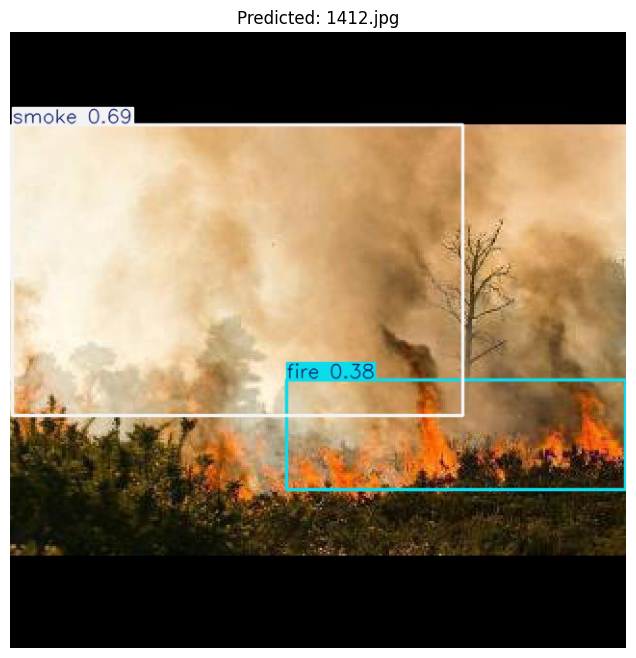


image 1/1 /kaggle/input/disaster-response-object-detection-dataset/val/images/1248.jpg: 640x640 1 fire, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


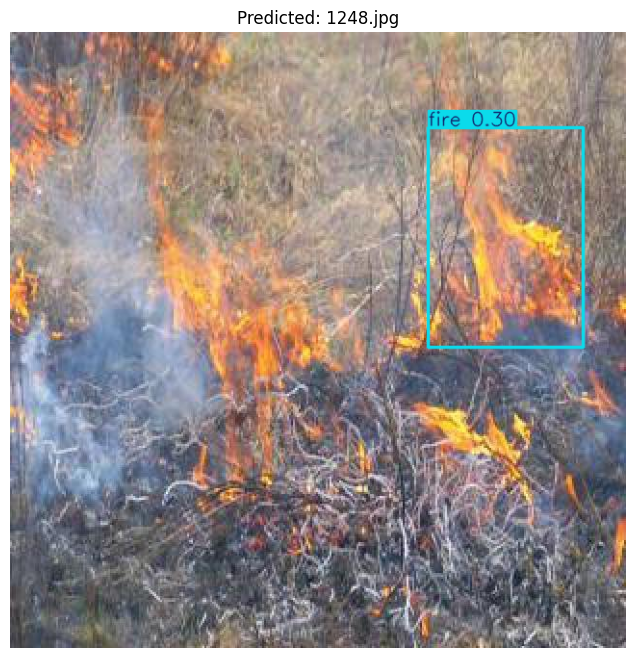


image 1/1 /kaggle/input/disaster-response-object-detection-dataset/val/images/855.jpg: 224x640 1 small_vehicle, 47.2ms
Speed: 1.3ms preprocess, 47.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)


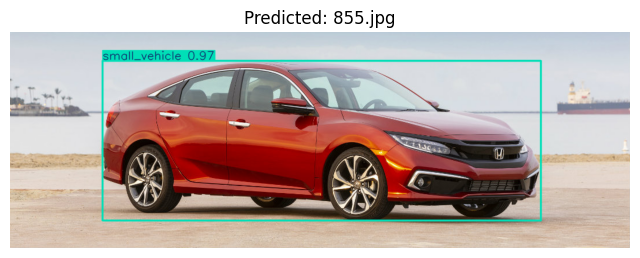

In [7]:
data_cfg = {
    "train": "/kaggle/input/disaster-response-object-detection-dataset/train/images",
    "val": "/kaggle/input/disaster-response-object-detection-dataset/val/images",
    "test": "/kaggle/input/disaster-response-object-detection-dataset/test/images",
    "nc": 6,
    "names": [
        "person", "fire", "smoke", "small_vehicle", "large_vehicle", "two_wheeler"
    ]
}

# ------------------------------------------------------------
# 3️⃣ Pick random validation images and run inference
# ------------------------------------------------------------
print("\n🧠 Running inference for visualization...")

val_dir = Path(data_cfg["val"])

# Collect all image files (jpg, jpeg, png)
img_files = list(val_dir.glob("*.jpg")) + list(val_dir.glob("*.jpeg")) + list(val_dir.glob("*.png"))

if len(img_files) == 0:
    raise ValueError(f"No images found in validation directory: {val_dir}")

# Pick min(3, total images) to avoid errors
sample_imgs = random.sample(img_files, min(3, len(img_files)))

for img_path in sample_imgs:
    results = model(img_path)           # Run YOLO inference
    annotated = results[0].plot()       # Draw predictions

    # Convert BGR to RGB for matplotlib
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {img_path.name}")
    plt.show()

# XAI

In [8]:
!git clone https://github.com/THU-MIG/yolov10.git



Cloning into 'yolov10'...
remote: Enumerating objects: 20338, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 20338 (delta 2), reused 0 (delta 0), pack-reused 20334 (from 2)
Receiving objects: 100% (20338/20338), 11.10 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (14354/14354), done.


In [9]:
%cd /kaggle/working/yolov10

/kaggle/working/yolov10


In [10]:
!pip install ttach

In [11]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

ModuleNotFoundError: No module named 'yolo_cam'

In [ ]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/disaster_response_object_yolov10_train/yolov10_disaster/weights/best.pt")
model = model.cpu()   # or model.to("cuda") if you want GPU

In [ ]:
import numpy as np 

In [ ]:
img = cv2.imread('/kaggle/input/disaster-response-object-detection-dataset/test/images/10.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [ ]:
target_layers =[model.model.model[-2]]